# NIFTY50 stocks analysis system.
**Notebook containing various stock indicators generation and analysis.**

We will work on the sensex stocks (30 Companies) for the time being.

Importing necessary packages

In [1]:
from os import listdir
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from livelossplot import PlotLossesKeras
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')
%autosave 30

Autosaving every 30 seconds


In [2]:
dft = pd.read_csv(r'C:\Users\asuto\Desktop\Work\Datasets\NIFTY50\NIFTYMASTERDATA.csv',index_col='Date',
                  parse_dates=True)
comps = dft.Symbol.unique()

## Below are the companies the model will be monitoring

In [3]:
comps

array(['ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV',
       'BAJFINANCE', 'BHARTIARTL', 'BPCL', 'BRITANNIA', 'CIPLA',
       'COALINDIA', 'DRREDDY', 'EICHERMOT', 'GAIL', 'GRASIM', 'HCLTECH',
       'HDFC', 'HDFCBANK', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR',
       'ICICIBANK', 'INDUSINDBK', 'INFY', 'IOC', 'ITC', 'JSWSTEEL',
       'KOTAKBANK', 'LT', 'MARUTI', 'MM', 'NESTLEIND', 'NTPC', 'ONGC',
       'POWERGRID', 'RELIANCE', 'SBIN', 'SHREECEM', 'SUNPHARMA',
       'TATAMOTORS', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO',
       'UPL', 'VEDL', 'WIPRO', 'ZEEL'], dtype=object)

In [4]:
comp30 = ['INFY','TCS','RELIANCE','ICICIBANK','HDFC','HCLTECH','BHARTIARTL',
          'INDUSINDBK','SBIN','LT','TECHM','MM','AXISBANK','ITC','BAJAJ-AUTO','ONGC',
          'TATASTEEL','NTPC','TECHM','ASIANPAINT','POWERGRID','BAJAJFINSV','TITAN','NESTLEIND',
          'ULTRACEMCO','MARUTI','HDFCBANK','HINDUNILVR','SUNPHARMA','KOTAKBANK'  
         ]
len(comp30)

30

## Various columns and the dataframe itself

In [5]:
cols = ['Symbol','Prev Close', 'Open', 'High', 'Low','Close' ,'Last','Volume', 'Turnover']
dft

,Symbol,Prev Close,Open,High,Low,Close,Last,Volume,Turnover
Date,,,,,,,,,
2010-11-04,ADANIPORTS,159.90,161.0,163.00,160.30,161.20,161.05,835546,1.348395e+13
2010-11-05,ADANIPORTS,161.20,163.0,163.00,161.60,162.30,162.35,187158,3.037435e+12
2010-11-08,ADANIPORTS,162.30,162.5,163.45,160.20,161.40,161.30,613082,9.911300e+12
2010-11-09,ADANIPORTS,161.40,162.5,165.00,161.35,162.25,162.40,601933,9.825511e+12
2010-11-10,ADANIPORTS,162.25,162.5,162.90,159.55,159.90,160.00,423032,6.795621e+12
...,...,...,...,...,...,...,...,...,...
2021-04-26,ZEEL,188.00,190.6,191.10,185.10,186.40,186.70,8542755,1.600451e+14
2021-04-27,ZEEL,186.40,188.0,192.95,186.80,188.15,188.80,14247767,2.698636e+14
2021-04-28,ZEEL,188.15,188.8,190.60,187.10,189.10,188.95,8429439,1.591917e+14


## Get Data Function

In [6]:
def get_data(stock,feature):
    return dft[dft.Symbol == stock][feature]

## Multi Stock Training

In [7]:
dy = lambda dti: int(dti.strftime('%d'))
mn = lambda dti: int(dti.strftime('%m'))
yr = lambda dti: int(dti.strftime('%Y'))

def generate_data(stock,slow=26,fast=12,smooth=9,lookback=14):
    op = get_data(stock,'Open') # Open
    cl = get_data(stock,'Close') # Close
    vol = get_data(stock,'Volume') # Volume
    #diff = cl-op # Daily Difference
    ewa1 = op.ewm(span=slow,min_periods=0,adjust=False).mean()
    datf = ewa1.diff() # Consecutive Day Difference
    ewa2 = op.ewm(span=fast,min_periods=0,adjust=False).mean()
    macd = ewa2-ewa1
    signal = macd.ewm(span=smooth,min_periods=0,adjust=False).mean().values
    hist = macd - signal # MACD Difference
    
    #datf = op.diff()
    
    up = []
    down = []
    for i in range(len(datf)):
        if datf[i] < 0:
            up.append(0)
            down.append(datf[i])
        else:
            up.append(datf[i])
            down.append(0)
            
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs)) # RSI
    
    op2 = op.reset_index()
    
    day = op2.Date.apply(dy).values
    month = op2.Date.apply(mn).values
    year = op2.Date.apply(yr).values
    
    final = {'open':op.values,'close':cl.values,'volume':vol,'cdiff':datf.values,
             'macdhist':hist.values,'rsi':rsi.values,'day':day,'month':month,'year':year
            }
    
    df = pd.DataFrame(final)
    df.set_index(op.index,inplace=True)
    df.interpolate(limit_direction ='backward',methoh = 'linear',inplace=True)
    
    return df
    

In [8]:
comps

array(['ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV',
       'BAJFINANCE', 'BHARTIARTL', 'BPCL', 'BRITANNIA', 'CIPLA',
       'COALINDIA', 'DRREDDY', 'EICHERMOT', 'GAIL', 'GRASIM', 'HCLTECH',
       'HDFC', 'HDFCBANK', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR',
       'ICICIBANK', 'INDUSINDBK', 'INFY', 'IOC', 'ITC', 'JSWSTEEL',
       'KOTAKBANK', 'LT', 'MARUTI', 'MM', 'NESTLEIND', 'NTPC', 'ONGC',
       'POWERGRID', 'RELIANCE', 'SBIN', 'SHREECEM', 'SUNPHARMA',
       'TATAMOTORS', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO',
       'UPL', 'VEDL', 'WIPRO', 'ZEEL'], dtype=object)

In [9]:
grand = []
for cm in tqdm(['INFY','TCS','RELIANCE','ICICIBANK','HDFC']):
    datacm = generate_data(cm)
    grand.append(datacm)

df = pd.concat(grand)
df

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.06it/s]


,open,close,volume,cdiff,macdhist,rsi,day,month,year
Date,,,,,,,,,
2010-11-04,3044.00,3077.15,689349,2.959259,0.000000,100.000000,4,11,2010
2010-11-05,3083.95,3081.65,78995,2.959259,2.549516,100.000000,5,11,2010
2010-11-08,3084.00,3015.90,672690,2.743759,4.011233,100.000000,8,11,2010
2010-11-09,3036.80,3059.80,658370,-0.955779,1.689986,97.563407,9,11,2010
2010-11-10,3048.00,3082.65,1216054,-0.055351,0.842435,97.415372,10,11,2010
...,...,...,...,...,...,...,...,...,...
2021-04-26,2500.00,2509.80,3916088,-1.193220,1.690897,14.303134,26,4,2021
2021-04-27,2494.15,2518.40,2040799,-1.538167,3.177203,13.958682,27,4,2021
2021-04-28,2516.10,2577.00,3407461,0.201697,5.584517,14.250298,28,4,2021


In [10]:
dftest = generate_data('TCS')
dftest

,open,close,volume,cdiff,macdhist,rsi,day,month,year
Date,,,,,,,,,
2010-11-04,1062.00,1069.15,858720,1.548148,0.000000,100.000000,4,11,2010
2010-11-05,1082.90,1077.75,179483,1.548148,1.333789,100.000000,5,11,2010
2010-11-08,1080.00,1068.15,1124293,1.218656,1.911752,100.000000,8,11,2010
2010-11-09,1073.90,1091.10,1752043,0.676533,1.777105,100.000000,9,11,2010
2010-11-10,1092.25,1092.30,770112,1.985679,2.759159,100.000000,10,11,2010
...,...,...,...,...,...,...,...,...,...
2021-04-26,3102.05,3100.80,2490260,-4.774938,-18.735632,74.337672,26,4,2021
2021-04-27,3106.00,3132.00,1471417,-4.128646,-19.931465,70.226706,27,4,2021
2021-04-28,3149.95,3124.10,1639037,-0.567265,-17.059409,69.656724,28,4,2021


In [11]:
ipfea = ['open','cdiff','macdhist','rsi','volume','month']
#ipfea = ['open','cdiff','macdhist','rsi','volume']
#opfea = ['close']
opfea = ['open']


scaip = StandardScaler()
scaop = StandardScaler()
scaop.fit(df[opfea])
df[ipfea] = scaip.fit_transform(df[ipfea])

#df_sca = pd.DataFrame(sca.fit_transform(df),columns=df.columns)

In [12]:
df


,open,close,volume,cdiff,macdhist,rsi,day,month,year
Date,,,,,,,,,
2010-11-04,2.057371,3077.15,-0.591442,0.360636,0.000798,1.266000,4,1.299286,2010
2010-11-05,2.107078,3081.65,-0.660065,0.360636,0.181369,1.266000,5,1.299286,2010
2010-11-08,2.107140,3015.90,-0.593315,0.332579,0.284896,1.266000,8,1.299286,2010
2010-11-09,2.048413,3059.80,-0.594925,-0.149094,0.120492,1.194426,9,1.299286,2010
2010-11-10,2.062348,3082.65,-0.532223,-0.031860,0.060464,1.190077,10,1.299286,2010
...,...,...,...,...,...,...,...,...,...
2021-04-26,1.380520,2509.80,-0.228651,-0.180008,0.120557,-1.251329,26,-0.697572,2021
2021-04-27,1.373241,2518.40,-0.439495,-0.224920,0.225825,-1.261447,27,-0.697572,2021
2021-04-28,1.400552,2577.00,-0.285838,0.001607,0.396325,-1.252881,28,-0.697572,2021


In [13]:
dftest[ipfea] = scaip.transform(dftest[ipfea])
dftest

,open,close,volume,cdiff,macdhist,rsi,day,month,year
Date,,,,,,,,,
2010-11-04,-0.408658,1069.15,-0.572399,0.176912,0.000798,1.266000,4,1.299286,2010
2010-11-05,-0.382653,1077.75,-0.648767,0.176912,0.095265,1.266000,5,1.299286,2010
2010-11-08,-0.386262,1068.15,-0.542540,0.134013,0.136199,1.266000,8,1.299286,2010
2010-11-09,-0.393851,1091.10,-0.471960,0.063430,0.126663,1.266000,9,1.299286,2010
2010-11-10,-0.371020,1092.30,-0.582361,0.233878,0.196217,1.266000,10,1.299286,2010
...,...,...,...,...,...,...,...,...,...
2021-04-26,2.129598,3100.80,-0.388961,-0.646341,-1.326164,0.512174,26,-0.697572,2021
2021-04-27,2.134513,3132.00,-0.503512,-0.562195,-1.410860,0.391415,27,-0.697572,2021
2021-04-28,2.189196,3124.10,-0.484666,-0.098510,-1.207445,0.374672,28,-0.697572,2021


In [14]:
def chunk(data,window=7,ahead=1):
    iparr,oparr = [],[]
    for i in tqdm(range(data.shape[0]-window-ahead)):
        iparr.append(data[ipfea].iloc[i:i+window])
        opt = data[opfea].iloc[i+window:i+window+ahead].values.ravel().tolist()
        #opt = data[opfea].iloc[i+window:i+window+ahead].values.ravel()
        oparr.append(opt)
        #oparr.append(data[opfea].iloc[i+window])
    iparr,oparr = np.array(iparr),np.array(oparr)
    #iparr = np.array(iparr)
    print(iparr.shape,oparr.shape)
    return iparr,oparr    
       

In [15]:
%%time
print(df.shape)
date = '2021-01-01'
ips,ops = chunk(df,window = 30,ahead = 7)
ipt,opt = chunk(dftest,window = 30,ahead = 7)
#tt = chunk(df.loc[date:],ahead=2)

(12990, 9)


100%|███████████████████████████████████████████████████████████████████████████| 12953/12953 [00:26<00:00, 481.68it/s]


(12953, 30, 6) (12953, 7)


100%|█████████████████████████████████████████████████████████████████████████████| 2561/2561 [00:02<00:00, 996.84it/s]


(2561, 30, 6) (2561, 7)
CPU times: total: 34.1 s
Wall time: 34.5 s


In [16]:
%%time
ipx,opx = shuffle(ips,ops,random_state=32)

CPU times: total: 15.6 ms
Wall time: 19.9 ms


In [17]:
import tensorflow as tf
from tensorflow import keras

bestparms = {'act': 'tanh',
 'batch': 32,
 'drp': 0.3,
 'lr': 0.002304610672382999,
 'epoch': 55,
 'layers': 7,
 'units': 90}
bestparms

{'act': 'tanh',
 'batch': 32,
 'drp': 0.3,
 'lr': 0.002304610672382999,
 'epoch': 55,
 'layers': 7,
 'units': 90}

In [18]:
act = bestparms['act']
drp = bestparms['drp']
model = tf.keras.models.Sequential([
                           tf.keras.layers.GRU(units=50,activation=act,return_sequences=True,
                                                input_shape=(ipx.shape[1],ipx.shape[2])),
                           tf.keras.layers.GRU(units=100,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=100,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
    
                           #tf.keras.layers.GRU(units=128,activation=act,return_sequences=True),
                           #tf.keras.layers.Dropout(drp),
                           #tf.keras.layers.GRU(units=128,activation=act,return_sequences=True),
                           #tf.keras.layers.Dropout(drp),
    
                           tf.keras.layers.GRU(units=100,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=64,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=34,activation='tanh',return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=7,activation=act),
                           tf.keras.layers.Dense(units=7)
                          ])

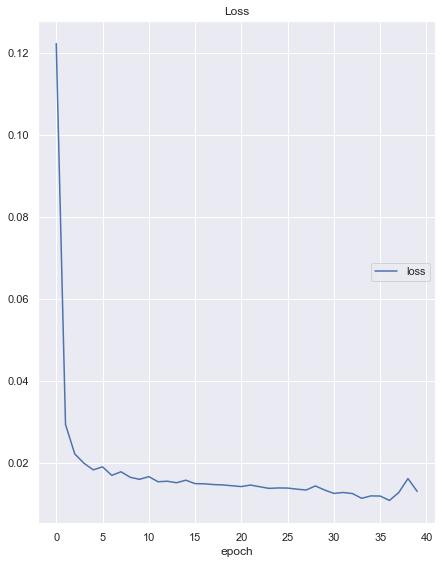

Loss
	loss             	 (min:    0.011, max:    0.122, cur:    0.013)
CPU times: total: 2min 52s
Wall time: 2min 27s


In [20]:
%%time
tf.keras.backend.clear_session()

opti = tf.optimizers.Adam(learning_rate=bestparms['lr'])
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',min_lr=0.0001,factor = 0.05)
early_stp = tf.keras.callbacks.EarlyStopping('loss',patience=25)


model.compile(optimizer=opti,loss='mean_squared_error')
history=model.fit(ipx,opx,epochs=40,batch_size=64,verbose=0,callbacks=[PlotLossesKeras(),early_stp,reduce_lr])

In [22]:
# dftest = generate_data('TCS')
# dftest[ipfea] = scaip.fit_transform(dftest[ipfea])
# ipt,opt = chunk(dftest,window = 10,ahead = 5)

9656.98828125


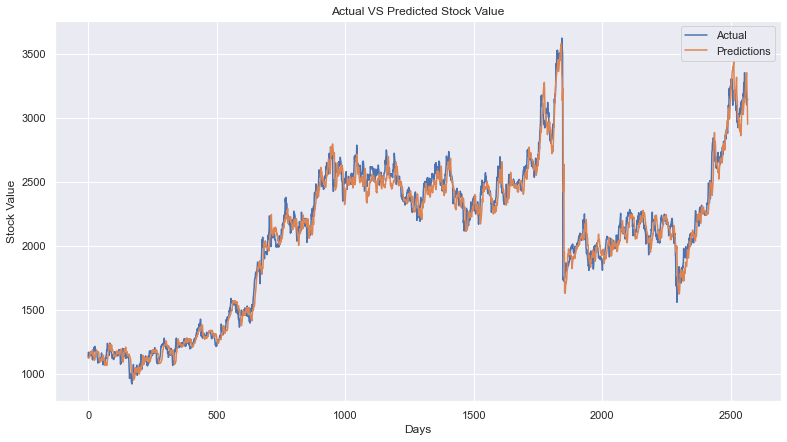

In [21]:
def plot_res(model=model,ipx=ipt,opx=opt,scaled = True):
    opp = model.predict(ipx)
    des = {'act':opx[0].tolist(),'pred':opp[0].tolist()}
    for i in range(1,len(opp)):
        des['act'].append(opx[i][-1])
        des['pred'].append(opp[i][-1])
    
    plt.figure(figsize=(13,7))
    if scaled:
        plt.plot(des['act'],label = 'Actual')
        plt.plot(des['pred'], label = 'Predictions')
        lossfn = tf.keras.losses.MeanSquaredError()
        print(lossfn(opx,opp).numpy())
    else:
        tt = np.array(des['act']).reshape(-1,1)
        tt
        scaop.inverse_transform(tt)
        opx1 = scaop.inverse_transform(np.array(des['act']).reshape(-1,1))
        opp1 = scaop.inverse_transform(np.array(des['pred']).reshape(-1,1))
        plt.plot(opx1,label = 'Actual')
        plt.plot(opp1, label = 'Predictions')
        lossfn = tf.keras.losses.MeanSquaredError()
        print(lossfn(opx1,opp1).numpy())
    
    plt.xlabel('Days')
    plt.ylabel('Stock Value')
    plt.title("Actual VS Predicted Stock Value")    
    plt.legend()
    return

plot_res(ipx=ipt,opx=opt,scaled = False)

In [22]:
color = lambda data:'green' if data[0]<data[-1] else 'red'

def plot_trace(model=model,ipx=ipt,opx=opt,visual='prediction'):
    opp = model.predict(ipx)
    des = {'actual':[],'prediction':[],'acttrace':[],'predtrace':[],'xaxis':[]}
    for i in range(len(opp)):
        #print(i)
        des['actual'].append(opt[i][0])
        des['prediction'].append(opp[i][0])
        #des['acttrace'].append([opt[i][0],opt[i][-1]])
        #des['predtrace'].append([opp[i][0],opp[i][-1]])
        
        des['acttrace'].append([ipx[i][-1][0],opx[i][-1]])
        des['predtrace'].append([ipx[i][-1][0],opp[i][-1]])
        des['xaxis'].append([i,i+5])  
        
    if visual == 'actual':
        plt.figure(figsize=(13,7))
        plt.plot(des['actual'],'o--k')
        for i in range(len(des['acttrace'])):
            plt.plot(des['xaxis'][i],des['acttrace'][i],color = color(des['acttrace'][i]))
        plt.title('Actual Trace')
            
    elif visual == 'prediction':
        plt.figure(figsize=(13,7))
        #plt.plot(des['prediction'],'o--k')
        plt.plot(des['actual'],'o--k')
        for i in range(len(des['predtrace'])):
            plt.plot(des['xaxis'][i],des['predtrace'][i],color = color(des['predtrace'][i])) 
        plt.title("Prediction Trace")
    return des

#des=plot_trace(ipx=ipt,opx=opt,visual = 'actual')

In [25]:
%%time
df = generate_data('MARUTI')
df.head()
df[ipfea] = scaip.fit_transform(df[ipfea])
#plot_data(df)

#ipt,opt = chunk(df.loc['2012-01-01':'2016-01-01'],window = 0,ahead = 7)
ipt,opt = chunk(df,window = 30,ahead = 7)

100%|█████████████████████████████████████████████████████████████████████████████| 2561/2561 [00:02<00:00, 954.95it/s]


(2561, 30, 6) (2561, 7)
CPU times: total: 2.86 s
Wall time: 2.86 s


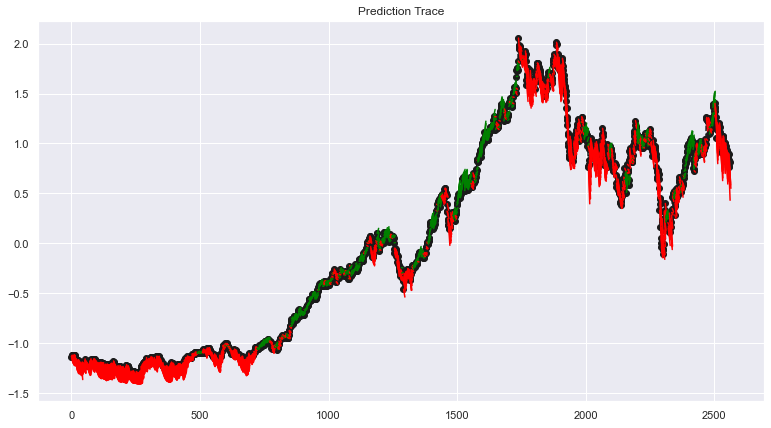

In [26]:
des=plot_trace(ipx=ipt,opx=opt,visual = 'prediction')

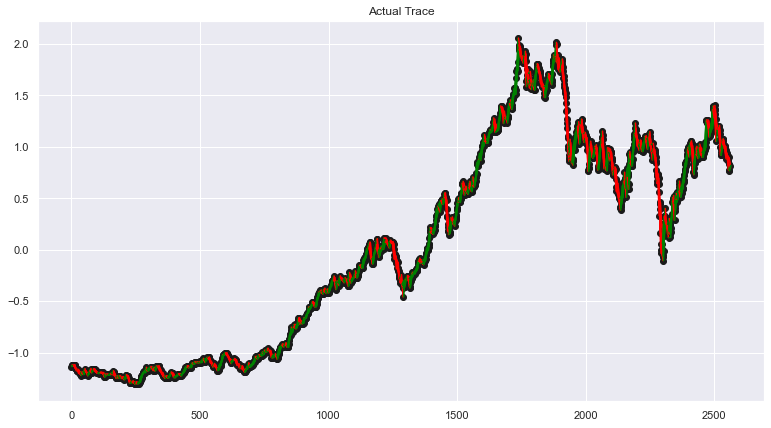

In [27]:
des=plot_trace(ipx=ipt,opx=opt,visual = 'actual')